In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cvxpy as cv

In [2]:
def create_py_problem(W, n):
    X = cv.Variable((n , n), integer = True)
    rest = []

    for i in range(n):
        v = np.zeros((n, 1))
        u = np.ones((n, 1))
        v[i] = 1
        rest.append( v.T @ X @ u == 1)
        rest.append( u.T @ X @ v == 1)
        if i == 0:
            s = v.T @ W @ X.T @ v
        else:
            s += v.T @ W @ X.T @ v

    obj = cv.Minimize(s)

    rest.append(X >= 0)
    rest.append(X <= 1)

    problem = cv.Problem(obj, rest)
    problem.solve()
    return (X.value, problem.value)

def replace_col(M, n, m):
    A = np.eye(M)
    aux = np.copy(A[:, n])
    A[n, :] = A[m, :]
    A[m, :] = aux
    return A

def hillClimbing(min_max, obj, A, b, M, x_0, method = "first"):
    
    n,m = A.shape
    
    A = A.tolist()
    b = b.tolist()
    
    for i in range(m):
        aux = np.zeros((1, m))
        aux[0, i] = 1
        aux_1 = (-1)*aux
        aux = aux.tolist()[0]
        aux_1 = aux_1.tolist()[0]
        A.append(aux)
        b.append([1])
        A.append(aux_1)
        b.append([0])
        
    A = np.array(A).astype('int64')
    b = np.array(b)
    
    if min_max == 'max':
        factor = 1
    else:
        factor = -1
    
    x = x_0
        
    flag = True
    k = 0
    
    while flag:
        
        if method == "absolute_max":
            possibilities = []
        
        z = (obj @ x)[0,0]*factor
        
        stop = True
        
        for move in M:
            large = int(np.sqrt(m))
            x_d = (x.reshape((len(x)//large, large)) @ move).reshape((m, 1))
                
            if (A @ x_d <= b).all(): #Verificamos factibilidad
                if method == "first":
                    if (obj @ x_d)[0,0]*factor > z:
                        x = x_d
                        stop = False #Si encontramos una mejora, no tenemos que cortar el ciclo
                        break
                elif method == "absolute_max":
                    z_d = (obj @ x_d)[0,0]*factor
                    possibilities.append((z_d, x_d))
        
        if method == "absolute_max":
            try:
                possibilities.sort()
                x = possibilities[-1][1]
            except:
                z_aux = possibilities[0][0]
                x_aux = possibilities[0][1]
                for z_p, x_p in possibilities:
                    if z_p > z_aux:
                        x_aux = x_p
                        z_aux = z_p
                x_d = x_aux
                z_d = z_aux
            
            if z < (obj @ x_d)[0,0]*factor:
                stop = False #Si encontramos una mejora, no tenemos que cortar el ciclo
                x = x_d
        k += 1
        
        if stop: #Si no encontramos mejora, paramos
            flag = False
            
    return z*factor, x, k

def createProblem(n, min_val_cost, max_val_cost, method ):
    
    C = np.random.randint(min_val_cost, max_val_cost + 1, (n,n)) #Creacion de la matriz de costos
    C = C.reshape((1,n*n))
    
    X_0 = np.eye(n).reshape((n*n, 1)) #Creacion de la solucion factible inicial
    
    A = []
    b = []
    
    for i in range(n):
        row = []
        row_ = []
        col = []
        col_ = []
        for j in range(n*n):
            if i*n<= j< i*n+n:
                row.append(1)
                row_.append(-1)
            else:
                row.append(0)
                row_.append(0)
            if j % n == i:
                col.append(1)
                col_.append(-1)
            else:
                col.append(0)
                col_.append(0)

        A.append(row)
        b.append([1])

        A.append(row_)
        b.append([-1])

        A.append(col)
        b.append([1])

        A.append(col_)
        b.append([-1])
    
    A = np.array(A)
    b = np.array(b)
    
    M = []
    
    if method == "two":
        for i in range(n):
            for j in range(i + 1, n):
                M.append(replace_col(n, i, j))
    elif method == "three":
        for i in range(n):
            for j in range(i + 1, n):
                for k in range(j + 1, n):                    
                    M.append(replace_col(n, i, j) @ replace_col(n, i, k))
    
    return C, A, b, M, X_0

In [3]:
n_s = [i for i in range(4, 21)]
times_two_abs = []
times_two_first = []
times_three_abs = []
times_three_first = []

for n in n_s:
    
    obj, A, b, M, x_0 = createProblem(n, 1, 100, method = "two")
    
    start = time.time()
    hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
    end = time.time()
    times_two_abs.append(end - start)
    
    start = time.time()
    hillClimbing('min', obj, A, b, M, x_0, method = "first")
    end = time.time()
    times_two_first.append(end - start)
    
    
    obj, A, b, M, x_0 = createProblem(n, 1, 100, method = "three")
    
    start = time.time()
    hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
    end = time.time()
    times_three_abs.append(end - start)
    
    start = time.time()
    hillClimbing('min', obj, A, b, M, x_0, method = "first")
    end = time.time()
    times_three_first.append(end - start)

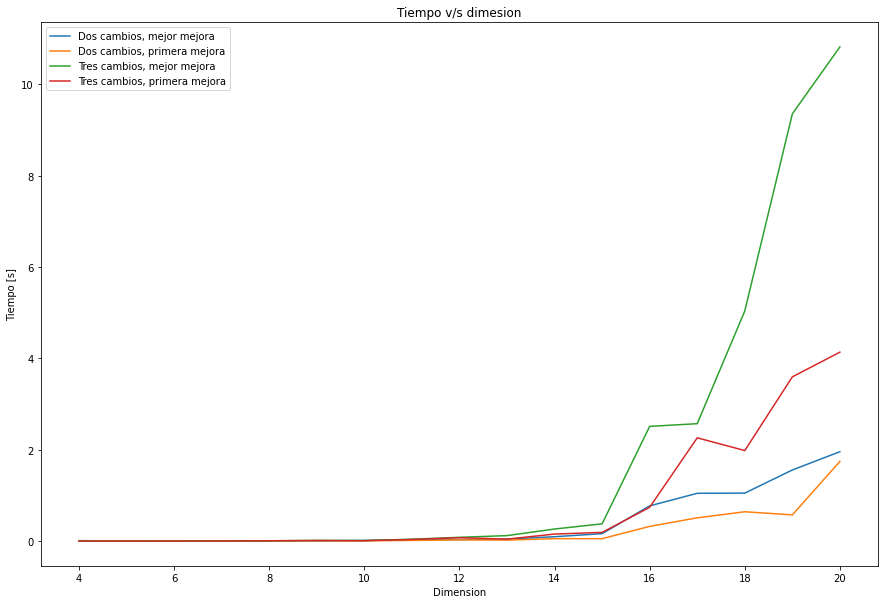

In [4]:
plt.figure(figsize = (15,10))
plt.plot(n_s, times_two_abs, label = "Dos cambios, mejor mejora")
plt.plot(n_s, times_two_first, label = "Dos cambios, primera mejora")
plt.plot(n_s, times_three_abs, label = "Tres cambios, mejor mejora")
plt.plot(n_s, times_three_first, label = "Tres cambios, primera mejora")
plt.ylabel("Tiempo [s]")
plt.xlabel("Dimension")
plt.title("Tiempo v/s dimesion")
plt.legend()
plt.show()

In [5]:
max_s = [30*i for i in range(1, 20)]
Max = 20
n = 10
times_two_abs = []
times_two_first = []
times_three_abs = []
times_three_first = []

for max_ in max_s:
    
    obj, A, b, M, x_0 = createProblem(n, 1, max_, method = "two")
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        end = time.time()
        s.append(end - start)
    times_two_abs.append(np.mean(s))
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "first")
        end = time.time()
        s.append(end - start)
    times_two_first.append(np.mean(s))
    
    
    obj, A, b, M, x_0 = createProblem(n, 1, max_, method = "three")
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        end = time.time()
        s.append(end - start)
    times_three_abs.append(np.mean(s))
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "first")
        end = time.time()
        s.append(end - start)
    times_three_first.append(np.mean(s))

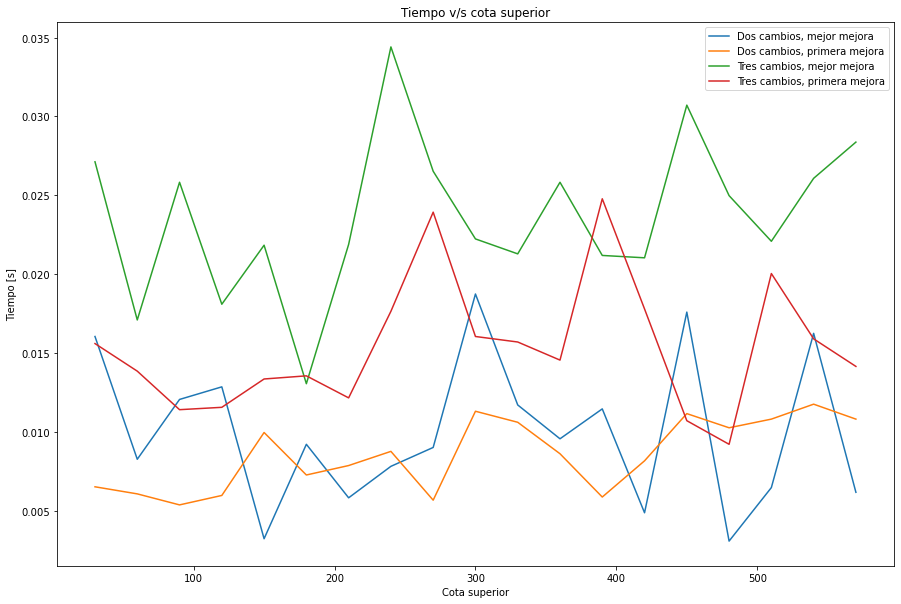

In [6]:
plt.figure(figsize = (15,10))
plt.plot(max_s, times_two_abs, label = "Dos cambios, mejor mejora")
plt.plot(max_s, times_two_first, label = "Dos cambios, primera mejora")
plt.plot(max_s, times_three_abs, label = "Tres cambios, mejor mejora")
plt.plot(max_s, times_three_first, label = "Tres cambios, primera mejora")
plt.ylabel("Tiempo [s]")
plt.xlabel("Cota superior")
plt.title("Tiempo v/s cota superior")
plt.legend()
plt.show()

In [7]:
min_s = [30*i for i in range(1, 20)]
Max = 20
n = 10
times_two_abs = []
times_two_first = []
times_three_abs = []
times_three_first = []

for min_ in min_s:
    
    obj, A, b, M, x_0 = createProblem(n, min_, 1000, method = "two")
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        end = time.time()
        s.append(end - start)
    times_two_abs.append(np.mean(s))
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "first")
        end = time.time()
        s.append(end - start)
    times_two_first.append(np.mean(s))
    
    
    obj, A, b, M, x_0 = createProblem(n, min_, 1000, method = "three")
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        end = time.time()
        s.append(end - start)
    times_three_abs.append(np.mean(s))
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "first")
        end = time.time()
        s.append(end - start)
    times_three_first.append(np.mean(s))

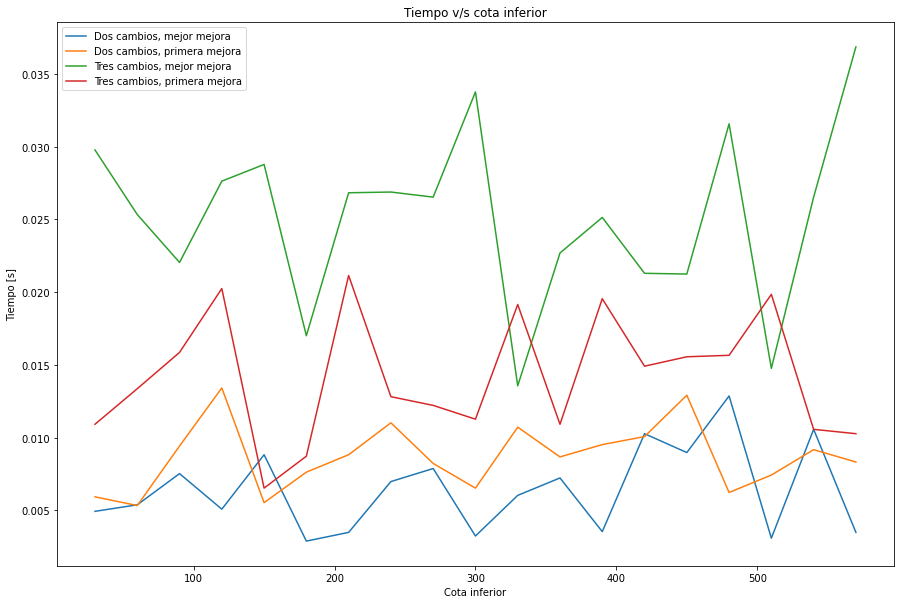

In [8]:
plt.figure(figsize = (15,10))
plt.plot(min_s, times_two_abs, label = "Dos cambios, mejor mejora")
plt.plot(min_s, times_two_first, label = "Dos cambios, primera mejora")
plt.plot(min_s, times_three_abs, label = "Tres cambios, mejor mejora")
plt.plot(min_s, times_three_first, label = "Tres cambios, primera mejora")
plt.ylabel("Tiempo [s]")
plt.xlabel("Cota inferior")
plt.title("Tiempo v/s cota inferior")
plt.legend()
plt.show()

In [9]:
delta_s = [50*i for i in range(1, 20)]
Max = 20
n = 10
times_two_abs = []
times_two_first = []
times_three_abs = []
times_three_first = []

for delta in delta_s:
    
    obj, A, b, M, x_0 = createProblem(n, 500 + delta, 1000 + delta, method = "two")
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        end = time.time()
        s.append(end - start)
    times_two_abs.append(np.mean(s))
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "first")
        end = time.time()
        s.append(end - start)
    times_two_first.append(np.mean(s))
    
    
    obj, A, b, M, x_0 = createProblem(n, 500 + delta, 1000 + delta, method = "three")
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        end = time.time()
        s.append(end - start)
    times_three_abs.append(np.mean(s))
    
    s = []
    for l in range(Max):
        start = time.time()
        hillClimbing('min', obj, A, b, M, x_0, method = "first")
        end = time.time()
        s.append(end - start)
    times_three_first.append(np.mean(s))

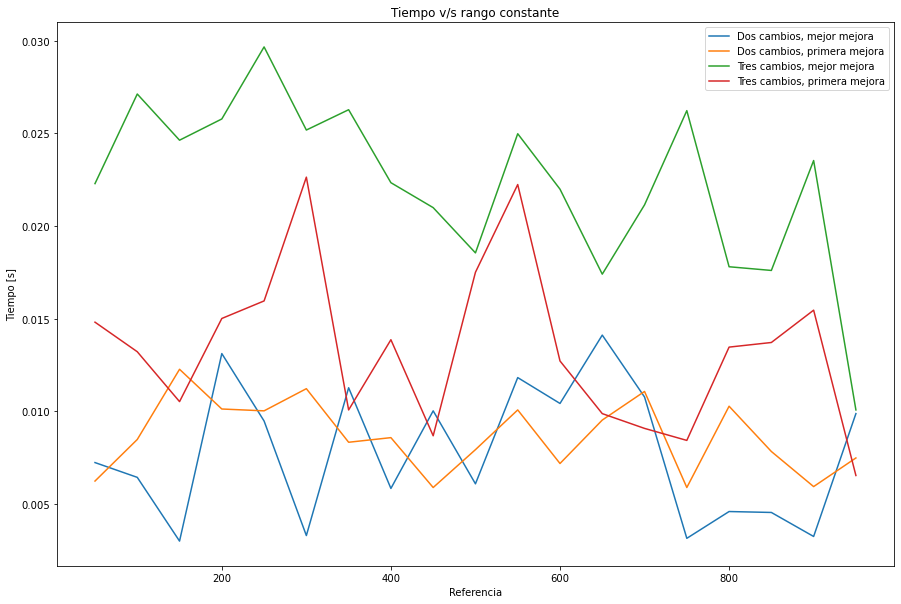

In [10]:
plt.figure(figsize = (15,10))
plt.plot(delta_s, times_two_abs, label = "Dos cambios, mejor mejora")
plt.plot(delta_s, times_two_first, label = "Dos cambios, primera mejora")
plt.plot(delta_s, times_three_abs, label = "Tres cambios, mejor mejora")
plt.plot(delta_s, times_three_first, label = "Tres cambios, primera mejora")
plt.ylabel("Tiempo [s]")
plt.xlabel("Referencia")
plt.title("Tiempo v/s rango constante")
plt.legend()
plt.show()

In [11]:
n_s = [i for i in range(4, 21)]
Max = 20
mean_two_abs = []
mean_two_first = []
mean_three_abs = []
mean_three_first = []

z_mean_two_abs = []
z_mean_two_first = []
z_mean_three_abs = []
z_mean_three_first = []

for n in n_s:
    two_abs = []
    two_first = []
    three_abs = []
    three_first = []
    z_two_abs = []
    z_two_first = []
    z_three_abs = []
    z_three_first = []
    for l in range(Max):
    
        obj, A, b, M, x_0 = createProblem(n, 1, 100, method = "two")
        x_ref, z_ref = create_py_problem(obj.reshape((n,n)), n)

        z,x,k = hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        two_abs.append(np.linalg.norm(x-x_ref.reshape((n*n, 1))))
        z_two_abs.append(abs(z-z_ref))

        z,x,k = hillClimbing('min', obj, A, b, M, x_0, method = "first")
        two_first.append(np.linalg.norm(x-x_ref.reshape((n*n, 1))))
        z_two_first.append(abs(z-z_ref))

        obj, A, b, M, x_0 = createProblem(n, 1, 100, method = "three")
        x_ref, z_ref = create_py_problem(obj.reshape((n,n)), n)

        z,x,k = hillClimbing('min', obj, A, b, M, x_0, method = "absolute_max")
        three_abs.append(np.linalg.norm(x-x_ref.reshape((n*n, 1))))
        z_three_abs.append(abs(z-z_ref))

        z,x,k = hillClimbing('min', obj, A, b, M, x_0, method = "first")
        three_first.append(np.linalg.norm(x-x_ref.reshape((n*n, 1))))
        z_three_first.append(abs(z-z_ref))
    mean_two_abs.append(np.mean(two_abs))
    mean_two_first.append(np.mean(two_first))
    mean_three_abs.append(np.mean(three_abs))
    mean_three_first.append(np.mean(three_first))
    
    z_mean_two_abs.append(np.mean(z_two_abs))
    z_mean_two_first.append(np.mean(z_two_first))
    z_mean_three_abs.append(np.mean(z_three_abs))
    z_mean_three_first .append(np.mean(z_three_first))

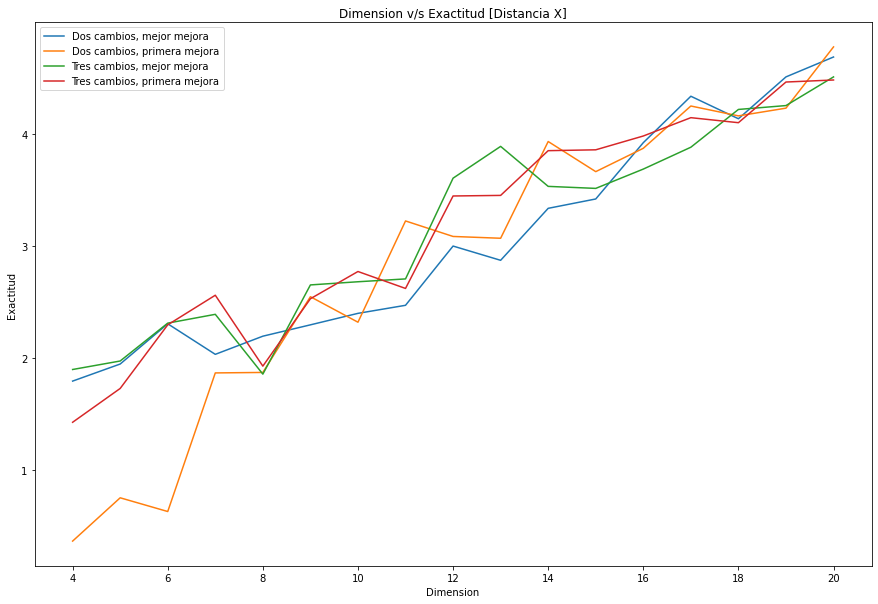

In [14]:
plt.figure(figsize = (15,10))
plt.plot(n_s, mean_two_abs, label = "Dos cambios, mejor mejora")
plt.plot(n_s, mean_two_first, label = "Dos cambios, primera mejora")
plt.plot(n_s, mean_three_abs, label = "Tres cambios, mejor mejora")
plt.plot(n_s, mean_three_first, label = "Tres cambios, primera mejora")
plt.ylabel("Exactitud")
plt.xlabel("Dimension")
plt.title("Dimension v/s Exactitud [Distancia X]")
plt.legend()
plt.show()

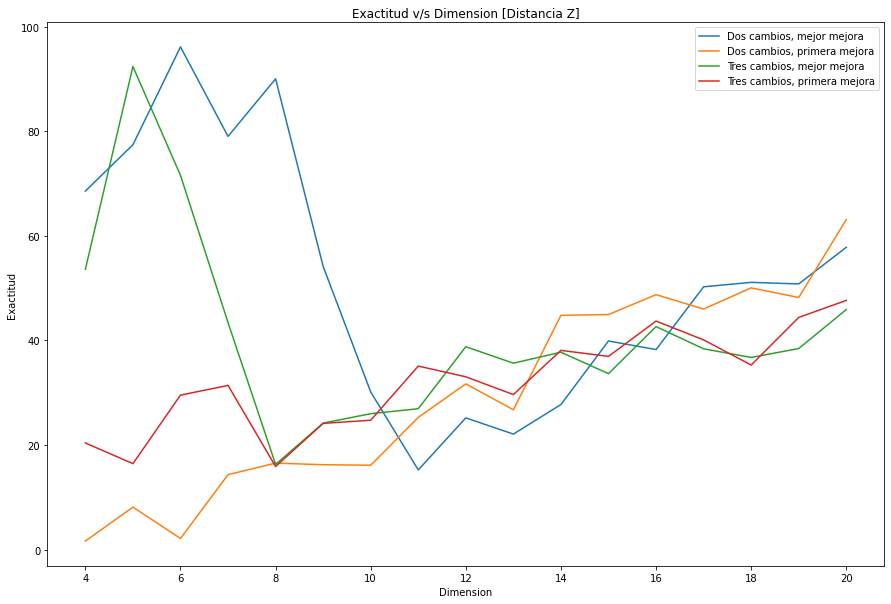

In [13]:
plt.figure(figsize = (15,10))
plt.plot(n_s, z_mean_two_abs, label = "Dos cambios, mejor mejora")
plt.plot(n_s, z_mean_two_first, label = "Dos cambios, primera mejora")
plt.plot(n_s, z_mean_three_abs, label = "Tres cambios, mejor mejora")
plt.plot(n_s, z_mean_three_first, label = "Tres cambios, primera mejora")
plt.ylabel("Exactitud")
plt.xlabel("Dimension")
plt.title("Exactitud v/s Dimension [Distancia Z]")
plt.legend()
plt.show()